In [62]:
import os, gc
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [64]:
input_path1 = Path("data/datasets/trashnet/")
input_path2 = Path("data/datasets/trashvariety/")

In [65]:
eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


source_ds = datasets.ImageFolder(input_path1 / "test",  transform= eval_tf)

target_ds = datasets.ImageFolder(input_path2, transform= eval_tf)

dataloader_source = DataLoader(
    source_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

dataloader_target = DataLoader(
    target_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

num_classes = len(target_ds.classes)


In [66]:
#Function to rebuild models for evaluation

def rebuild_model(filename: str, num_classes: int, device):
    
    if filename.startswith("resnet50"):
        m = models.resnet50(weights=None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)

    elif filename.startswith("densenet121"):
        m = models.densenet121(weights=None)
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)

    elif filename.startswith("convnext_tiny"):
        m = models.convnext_tiny(weights=None)
        m.classifier[2] = nn.Linear(m.classifier[2].in_features, num_classes)

    else:
        raise ValueError(f"Unknown architecture in filename: {filename}")

    return m.to(device)                            

In [67]:
#Function to calculate metrics

def evaluate_model_metrics(model, dataloader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            preds_list.extend(preds.cpu().tolist())
            labels_list.extend(labels.cpu().tolist())

        return {
            "accuracy": accuracy_score(labels_list, preds_list),
            "macro_precision": precision_score(labels_list, preds_list, average="macro", zero_division=0),
            "macro_recall": recall_score(labels_list, preds_list, average="macro", zero_division=0),
            "macro_f1": f1_score(labels_list, preds_list, average="macro", zero_division=0),
            "n": len(labels_list),
        }

In [68]:
#Calculating metrics for all the models

cnn_models_dir = "trained_models"
rows = []

for entry in sorted(os.listdir(cnn_models_dir)):
    if not entry.endswith(".pth"):
        continue

    ckpt_path = os.path.join(cnn_models_dir, entry)
    model_name = entry.replace(".pth", "")

    model = rebuild_model(entry, num_classes, device)

    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    src = evaluate_model_metrics(model, dataloader_source, device)
    tgt = evaluate_model_metrics(model, dataloader_target, device)

    rows.append({
        "model": model_name,

        "source_acc": src["accuracy"],
        "source_macro_precision": src["macro_precision"],
        "source_macro_recall": src["macro_recall"],
        "source_macro_f1": src["macro_f1"],

        "target_acc": tgt["accuracy"],
        "target_macro_precision": tgt["macro_precision"],
        "target_macro_recall": tgt["macro_recall"],
        "target_macro_f1": tgt["macro_f1"],

        "source_n": src["n"],
        "target_n": tgt["n"],
    })

    del model
    torch.cuda.empty_cache()

df = pd.DataFrame(rows)
metric_cols = [c for c in df.columns if c not in ["model", "source_n", "target_n"]]
df[metric_cols] = df[metric_cols].round(4)

df["macro_f1_drop"] = (df["source_macro_f1"] - df["target_macro_f1"]).round(4)

print(df.to_string(index=False))    

               model  source_acc  source_macro_precision  source_macro_recall  source_macro_f1  target_acc  target_macro_precision  target_macro_recall  target_macro_f1  source_n  target_n  macro_f1_drop
  convnext_tiny_base      0.9416                  0.9538               0.9015           0.9182      0.5063                  0.5813               0.5045           0.4918       257       478         0.4264
   convnext_tiny_geo      0.9183                  0.9092               0.8937           0.8996      0.4644                  0.5915               0.4631           0.4502       257       478         0.4494
 convnext_tiny_mixed      0.9455                  0.9557               0.9207           0.9341      0.5042                  0.6285               0.5027           0.4993       257       478         0.4348
 convnext_tiny_photo      0.9416                  0.9372               0.9322           0.9342      0.4916                  0.5526               0.4908           0.4885       257      

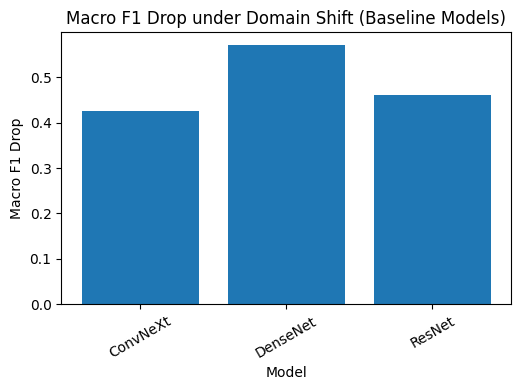

In [69]:
df["architecture"] = (
    df["model"]
      .str.split("_").str[0]
      .replace({
          "resnet50": "ResNet",
          "densenet121": "DenseNet",
          "convnext": "ConvNeXt"
      })
)

df_baseline = df[df["model"].str.contains("baseline|base")].copy()


plt.figure(figsize=(6, 4))

plt.bar(
    df_baseline["architecture"],
    df_baseline["macro_f1_drop"]
)

plt.title("Macro F1 Drop under Domain Shift (Baseline Models)")
plt.xlabel("Model")
plt.ylabel("Macro F1 Drop")
plt.xticks(rotation=30)
plt.subplots_adjust(bottom=0.2, left=0.15)
plt.savefig("images/MacroF1Baseline")
plt.show()


<Figure size 500x400 with 0 Axes>

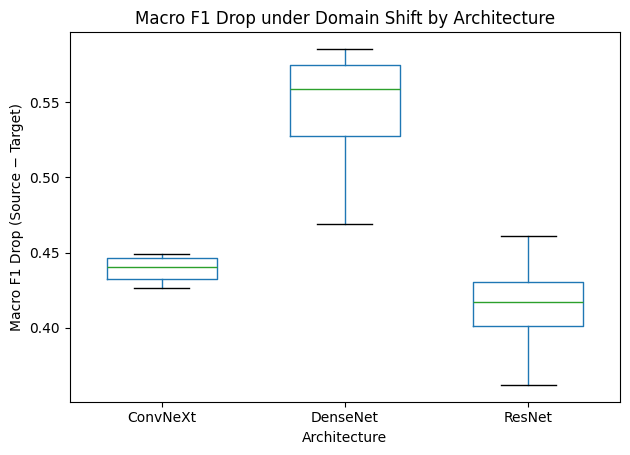

In [70]:
plt.figure(figsize=(5, 4))

df.boxplot(
    column="macro_f1_drop",
    by="architecture",
    grid=False,
    widths=0.6  
)

plt.title("Macro F1 Drop under Domain Shift by Architecture")
plt.suptitle("")
plt.xlabel("Architecture")
plt.ylabel("Macro F1 Drop (Source − Target)")
plt.tight_layout()
plt.savefig("images/MarcoF1byArchitecture.png")
plt.show()


In [71]:
def build_subgroup_folder(
    csv_path,
    images_root,
    out_root,
    filter_col,
    filter_value,        
    class_col="class",
    id_col="id",
    overwrite=True,
    copy_files=True    
):
    csv_path = Path(csv_path)
    images_root = Path(images_root)
    out_root = Path(out_root)

    df = pd.read_csv(csv_path)

    sub = df[df[filter_col] == filter_value].copy()
    subgroup_name = f"{filter_col}_{filter_value}"
    dst_root = out_root / subgroup_name

    if overwrite and dst_root.exists():
        shutil.rmtree(dst_root)
    dst_root.mkdir(parents=True, exist_ok=True)

    missing = 0
    written = 0

    for _, row in sub.iterrows():
        cls = str(row[class_col]).strip()
        fname = str(row[id_col]).strip()

        src = images_root / cls / fname
        if not src.exists():
            missing += 1
            continue

        dst_class_dir = dst_root / cls
        dst_class_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_class_dir / fname

        if copy_files:
            shutil.copy2(src, dst)
        else:
            if dst.exists():
                dst.unlink()
            dst.symlink_to(src.resolve())

        written += 1
        
    return dst_root


In [72]:
csv_path = "subgroups.csv"
images_root = input_path2
out_root = "subgroups"

low_light_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="lighting", filter_value=2,
                                       copy_files=True)

good_light_root = build_subgroup_folder(csv_path, images_root, out_root,
                                        filter_col="lighting", filter_value=1,
                                        copy_files=True)

background_tree_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="tree",
                                       copy_files=True)

background_wall_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="wall",
                                       copy_files=True)

background_white_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="white",
                                       copy_files=True)

background_floor_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="floor",
                                       copy_files=True)  

near_view_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="view", filter_value=1,
                                       copy_files=True)

far_view_root = build_subgroup_folder(csv_path, images_root, out_root,
                                        filter_col="view", filter_value=2,
                                        copy_files=True)                                                                                                                   

In [73]:
# Evaluate all models on all subgroups
subgroups_root = Path("subgroups")  
cnn_models_dir_path = Path(cnn_models_dir) 
rows = []

for entry in sorted(cnn_models_dir_path.iterdir()):
    if not entry.name.endswith(".pth"):
        continue

    model_name = entry.stem
    print(f"Evaluating model: {model_name}")

    model = rebuild_model(entry.name, num_classes, device)
    ckpt = torch.load(entry, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    model.eval()

    for sg_dir in sorted(subgroups_root.iterdir()):
        if not sg_dir.is_dir():
            continue

        ds = datasets.ImageFolder(sg_dir, transform=eval_tf)

        if len(ds) == 0:
            rows.append({
                "model": model_name,
                "subgroup": sg_dir.name,
                "accuracy": float("nan"),
                "macro_precision": float("nan"),
                "macro_recall": float("nan"),
                "macro_f1": float("nan"),
                "n": 0,
                "note": "empty subgroup"
            })
            continue

        loader = torch.utils.data.DataLoader(
            ds,
            batch_size=32,
            shuffle=False,
            num_workers=0 
        )

        metrics = evaluate_model_metrics(model, loader, device)

        rows.append({
            "model": model_name,
            "subgroup": sg_dir.name,
            "accuracy": metrics["accuracy"],
            "macro_precision": metrics["macro_precision"],
            "macro_recall": metrics["macro_recall"],
            "macro_f1": metrics["macro_f1"],
            "n": metrics["n"],
            "note": ""
        })

        print(
            f"  {sg_dir.name:20s} | "
            f"n={metrics['n']:4d} | "
            f"acc={metrics['accuracy']:.4f} | "
            f"macroF1={metrics['macro_f1']:.4f}"
        )

    del model
    torch.cuda.empty_cache()

df_subgroups = pd.DataFrame(rows)
metric_cols = [c for c in df_subgroups.columns if c not in ["model", "subgroup", "n", "note"]]
df_subgroups[metric_cols] = df_subgroups[metric_cols].round(4)

print("Subgroup Evaluation Results for All Models")
print(df_subgroups.to_string(index=False))

Evaluating model: convnext_tiny_base
  background_floor     | n= 120 | acc=0.5833 | macroF1=0.5632
  background_tree      | n= 120 | acc=0.3667 | macroF1=0.3466
  background_wall      | n= 118 | acc=0.5000 | macroF1=0.4654
  background_white     | n= 120 | acc=0.5750 | macroF1=0.5426
  lighting_1           | n= 239 | acc=0.5607 | macroF1=0.5468
  lighting_2           | n= 239 | acc=0.4519 | macroF1=0.4341
  view_1               | n= 240 | acc=0.5417 | macroF1=0.5296
  view_2               | n= 238 | acc=0.4706 | macroF1=0.4520
Evaluating model: convnext_tiny_geo
  background_floor     | n= 120 | acc=0.5333 | macroF1=0.5398
  background_tree      | n= 120 | acc=0.2833 | macroF1=0.2391
  background_wall      | n= 118 | acc=0.5085 | macroF1=0.4628
  background_white     | n= 120 | acc=0.5333 | macroF1=0.5192
  lighting_1           | n= 239 | acc=0.5105 | macroF1=0.5030
  lighting_2           | n= 239 | acc=0.4184 | macroF1=0.3926
  view_1               | n= 240 | acc=0.4875 | macroF1=0.46

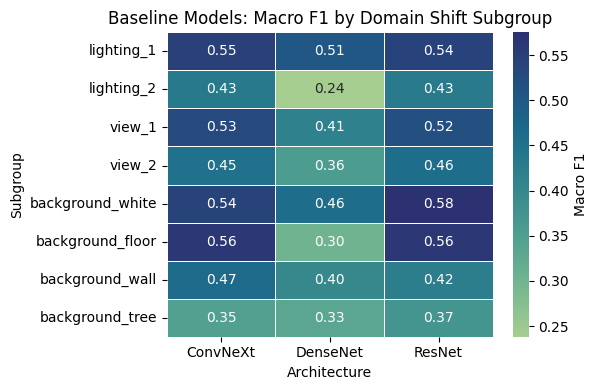

In [74]:
df_base = df_subgroups[df_subgroups["model"].str.contains("baseline|_base")].copy()

df_base["architecture"] = (
    df_base["model"]
      .str.split("_").str[0]
      .replace({
          "resnet50": "ResNet",
          "densenet121": "DenseNet",
          "convnext": "ConvNeXt"
      })
)

heat = df_base.pivot(index="subgroup", columns="architecture", values="macro_f1")

order = ["lighting_1","lighting_2","view_1","view_2",
         "background_white","background_floor","background_wall","background_tree"]
heat = heat.reindex(order)

plt.figure(figsize=(6, 4))

sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="crest",
    cbar_kws={"label": "Macro F1"},
    linewidths=0.5,
    linecolor="white"
)

plt.title("Baseline Models: Macro F1 by Domain Shift Subgroup")
plt.xlabel("Architecture")
plt.ylabel("Subgroup")

plt.tight_layout()
plt.savefig("images/HeatmapSubgroups")
plt.show()


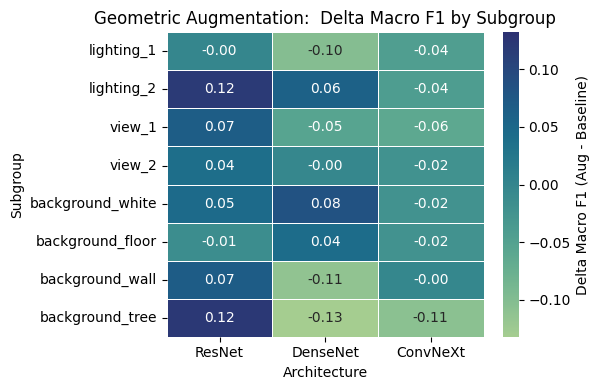

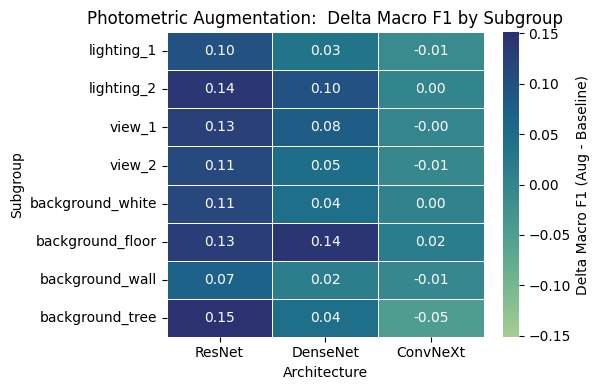

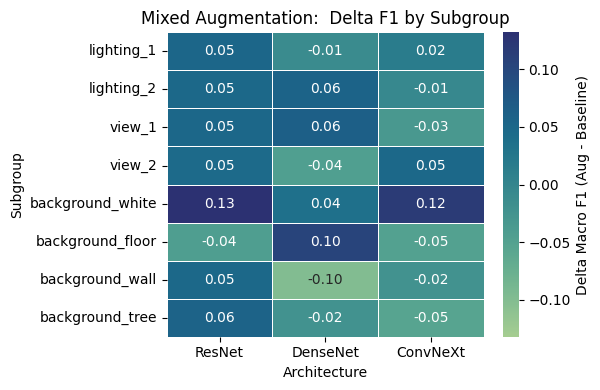

In [75]:
df_hm = df_subgroups.copy()

df_hm["architecture"] = (
    df_hm["model"]
      .str.split("_").str[0]
      .replace({
          "resnet50": "ResNet",
          "densenet121": "DenseNet",
          "convnext": "ConvNeXt"
      })
)

def get_aug(name: str):
    name = name.lower()
    if "baseline" in name or name.endswith("_base"):
        return "baseline"
    if "geo" in name:
        return "geometric"
    if "photo" in name:
        return "photometric"
    if "mixed" in name or "mix" in name:
        return "mixed"
    return "other"

df_hm["aug"] = df_hm["model"].apply(get_aug)

order = [
    "lighting_1","lighting_2",
    "view_1","view_2",
    "background_white","background_floor",
    "background_wall","background_tree"
]

def pivot_macro_f1(df, aug_name):
    heat = (df[df["aug"] == aug_name]
            .pivot(index="subgroup", columns="architecture", values="macro_f1")
            .reindex(index=order, columns=["ResNet", "DenseNet", "ConvNeXt"]))  # FIXED: Ensure consistent columns
    return heat

# Define consistent column order for verification
arch_order = ["ResNet", "DenseNet", "ConvNeXt"]

heat_base  = pivot_macro_f1(df_hm, "baseline")
heat_geo   = pivot_macro_f1(df_hm, "geometric")
heat_photo = pivot_macro_f1(df_hm, "photometric")
heat_mixed = pivot_macro_f1(df_hm, "mixed")


delta_geo   = heat_geo   - heat_base
delta_photo = heat_photo - heat_base
delta_mixed = heat_mixed - heat_base

def plot_delta_heatmap(delta, title, filename):
    vmax = np.nanmax(np.abs(delta.values)) 
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        delta,
        annot=True,
        fmt=".2f",
        center=0,
        vmin=-vmax, vmax=vmax,
        cmap="crest",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Delta Macro F1 (Aug - Baseline)"}
    )
    plt.title(title)
    plt.xlabel("Architecture")
    plt.ylabel("Subgroup")
    plt.tight_layout()
    plt.savefig(f"images/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

plot_delta_heatmap(delta_geo,   "Geometric Augmentation:  Delta Macro F1 by Subgroup",   "delta_geo_heatmap")
plot_delta_heatmap(delta_photo, "Photometric Augmentation:  Delta Macro F1 by Subgroup","delta_photo_heatmap")
plot_delta_heatmap(delta_mixed, "Mixed Augmentation:  Delta F1 by Subgroup",      "delta_mixed_heatmap")


In [76]:
cnn_models_dir = "trained_models"
class_names = target_ds.classes
rows = []

for fname in sorted(os.listdir(cnn_models_dir)):
    if not fname.endswith(".pth"):
        continue

    model_name = fname.replace(".pth", "")
    ckpt_path = os.path.join(cnn_models_dir, fname)

    # 1) rebuild + load
    model = rebuild_model(fname, num_classes, device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    # 2) predict on target
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader_target:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # 3) per-class report
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # 4) store per-class rows
    for cls in class_names:
        rows.append({
            "model": model_name,
            "class": cls,
            "precision": report[cls]["precision"],
            "recall": report[cls]["recall"],
            "f1": report[cls]["f1-score"],
            "support": int(report[cls]["support"]),
        })

    # optional: also store macro avg row per model (useful sanity check)
    rows.append({
        "model": model_name,
        "class": "MACRO_AVG",
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"],
        "support": int(report["macro avg"]["support"]),
    })

    # 5) cleanup
    del model, ckpt
    gc.collect()
    torch.cuda.empty_cache()

df_per_class = pd.DataFrame(rows)
df_per_class[["precision", "recall", "f1"]] = df_per_class[["precision", "recall", "f1"]].round(4)

df_per_class

,model,class,precision,recall,f1,support
0,convnext_tiny_base,cardboard,0.4179,0.7000,0.5234,80
1,convnext_tiny_base,glass,0.8333,0.6875,0.7534,80
2,convnext_tiny_base,metal,0.6620,0.5875,0.6225,80
3,convnext_tiny_base,paper,0.2923,0.4750,0.3619,80
4,convnext_tiny_base,plastic,0.5821,0.4875,0.5306,80
...,...,...,...,...,...,...
79,resnet50_photo,metal,0.7857,0.6875,0.7333,80
80,resnet50_photo,paper,0.4059,0.5125,0.4530,80
81,resnet50_photo,plastic,0.6512,0.7000,0.6747,80
82,resnet50_photo,trash,0.7097,0.2821,0.4037,78


In [77]:
print(df_per_class.to_string())

                   model      class  precision  recall      f1  support
0     convnext_tiny_base  cardboard     0.4179  0.7000  0.5234       80
1     convnext_tiny_base      glass     0.8333  0.6875  0.7534       80
2     convnext_tiny_base      metal     0.6620  0.5875  0.6225       80
3     convnext_tiny_base      paper     0.2923  0.4750  0.3619       80
4     convnext_tiny_base    plastic     0.5821  0.4875  0.5306       80
5     convnext_tiny_base      trash     0.7000  0.0897  0.1591       78
6     convnext_tiny_base  MACRO_AVG     0.5813  0.5045  0.4918      478
7      convnext_tiny_geo  cardboard     0.4340  0.5750  0.4946       80
8      convnext_tiny_geo      glass     0.8205  0.4000  0.5378       80
9      convnext_tiny_geo      metal     0.6087  0.3500  0.4444       80
10     convnext_tiny_geo      paper     0.3517  0.6375  0.4533       80
11     convnext_tiny_geo    plastic     0.4109  0.6625  0.5072       80
12     convnext_tiny_geo      trash     0.9231  0.1538  0.2637  